In [6]:
import pandas as pd
from datetime import datetime
import jovian_project.data_cleaning as dc
from sodapy import Socrata
import plotly.express as px

### Data Source
The data is from the 'Crime Data from 2020 to Present' Dataset by Los Angeles Police Department from the Los Angeles Open Data Portal. The data can be found [here](https://data.lacity.org/A-Safe-City/Crime-Data-from-2020-to-Present/2nrs-mtv8). It Contains all crimes reported to the LAPD from 2020 to present and it is updated daily. It contains more than 700,000 records and 26 columns. Data has been pulled in JSON format through the SODA API.

We then used the **pandas** library to import this data into a pandas dataframe.

In [7]:
client = Socrata("data.lacity.org", None)
results = client.get("2nrs-mtv8", limit=1000000)

In [8]:
#create a dataframe from the resulting data
crime_df = pd.DataFrame.from_records(results)

We now copy this dataframe and create a new one with the same data to clean and analyze.


In [9]:
cleaned_crime_df=crime_df.copy()

### Data Exploration and Cleaning
1. Drop redundant columns.
1. Check for the shape of the data and the data types of the columns.
2. Check for missing values in each column and replace them with appropriate values.
3. Check for duplicates and drop them.
4. Check for unique values in each column, Check for outliers and replace them with appropriate values.
5. Check for the correlation between the columns.


##### 1. Check for the shape of the data and the data types of the columns.
- The data has 28 columns and over 725,000 rows.
- The data types of the columns are mostly objects and we will have to change them to appropriate data types for analysis and visualization.
- *time occ* column (time of occurence) has 24 hour military time but it is in string format and the data has missing zeros. We will have to add zeros to the front of the entries that are less than 4 digits. We will also have to change the data type to time objects for easier analysis and visualization.

In [10]:
#check the shape of dataframe
print(cleaned_crime_df.shape)

(726531, 28)


In [11]:
#checking data types of columns
cleaned_crime_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 726531 entries, 0 to 726530
Data columns (total 28 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   dr_no           726531 non-null  object
 1   date_rptd       726531 non-null  object
 2   date_occ        726531 non-null  object
 3   time_occ        726531 non-null  object
 4   area            726531 non-null  object
 5   area_name       726531 non-null  object
 6   rpt_dist_no     726531 non-null  object
 7   part_1_2        726531 non-null  object
 8   crm_cd          726531 non-null  object
 9   crm_cd_desc     726531 non-null  object
 10  mocodes         626879 non-null  object
 11  vict_age        726531 non-null  object
 12  vict_sex        631696 non-null  object
 13  vict_descent    631690 non-null  object
 14  premis_cd       726522 non-null  object
 15  premis_desc     726124 non-null  object
 16  weapon_used_cd  252078 non-null  object
 17  weapon_desc     252078 non-nu

In [12]:
#convert vict_age, crm_cd, area, rpt_dist_no, dr_no  columns to interger
cleaned_crime_df['vict_age']=cleaned_crime_df['vict_age'].astype(int)
cleaned_crime_df['crm_cd']=cleaned_crime_df['crm_cd'].astype(int)
cleaned_crime_df['area']=cleaned_crime_df['area'].astype(int)
cleaned_crime_df['rpt_dist_no']=cleaned_crime_df['rpt_dist_no'].astype(int)
cleaned_crime_df['dr_no']=cleaned_crime_df['dr_no'].astype(int)


In [13]:
#converting longitude and latitude to float
cleaned_crime_df['lon']=cleaned_crime_df['lon'].astype(float)
cleaned_crime_df['lat']=cleaned_crime_df['lat'].astype(float)


In [14]:
#converting date_occ and date_rptd columns to pandas datetime objects
cleaned_crime_df['date_occ'] = pd.to_datetime(cleaned_crime_df['date_occ'], format='%Y-%m-%dT%H:%M:%S.%f').dt.date
cleaned_crime_df['date_rptd'] = pd.to_datetime(cleaned_crime_df['date_rptd'], format='%Y-%m-%dT%H:%M:%S.%f').dt.date

In [15]:
#converting time_occ(time of occurence) column from 24 hour military format with some values missing a few digits to pandas time objects
dc.edit_column(cleaned_crime_df, 'time_occ', dc.clean_military_time)
cleaned_crime_df['time_occ']=pd.to_datetime(cleaned_crime_df['time_occ'], format='%H:%M').dt.time

In [16]:
#check the columns of dataframe
print(cleaned_crime_df.columns)

Index(['dr_no', 'date_rptd', 'date_occ', 'time_occ', 'area', 'area_name',
       'rpt_dist_no', 'part_1_2', 'crm_cd', 'crm_cd_desc', 'mocodes',
       'vict_age', 'vict_sex', 'vict_descent', 'premis_cd', 'premis_desc',
       'weapon_used_cd', 'weapon_desc', 'status', 'status_desc', 'crm_cd_1',
       'location', 'lat', 'lon', 'crm_cd_2', 'cross_street', 'crm_cd_3',
       'crm_cd_4'],
      dtype='object')


##### 1. Drop redundant columns.
- **weapon_used_code** is redundant with weapon_description. Although it may be useful for machine learning purposes, it is not useful for EDA because it is a code and not a description.
- **status_code** is redundant with status_description. Status description is more descriptive, easier to understand and small in size.
- **crm_cd_1** is redundant with crm_cd. By definition, crm_cd_1 is the same as crm_cd. I will drop crm_cd_1.
- **mocodes, crm_cd_2, cross_street** all have missing values but they will not be used in the analysis so they will be dropped.
- **crm_cd_3 and crm_cd_4** are practically empty and will be dropped.

In [17]:
# Dropping the redundant columns
cleaned_crime_df.drop(columns=['weapon_used_cd', 'status', 'crm_cd_1','mocodes','part_1_2','cross_street', 'crm_cd_3', 'crm_cd_4','crm_cd_2'], inplace=True)


##### 2. Check for missing values in each column and replace them with appropriate values.<br>
We find the null values using isna() function and use sum() function to find the total number of null values in each column.

Here is how i dealt with the missing values in each column using Pandas *fillna()* method:
- **weapon_desc** (474450(approx) Missing values) - Even though approx half of the values are null, the known values will provide us good info about weapons used. Null values Replaced with 'UNKNOWN WEAPON/OTHER WEAPON' value already found in the column.
- **vict_sex** (94800(approx) Missing values) - Replaced with 'X' value already found in the column which represents unknown sex.
- **vict_descent** (94800(approx) Missing values) - Replaced with 'unknown' which will represents unknown descent.
- **premis_cd(9 missing values), premis_desc(407 missing values)** are analogous to each other. With exploration of these two columns we find that code 256 means unknown and has null values in the corresponding premis_desc column in the same row. Thus we fill missing values in premis_desc with 'unknown' and fill missing values in premis_cd with 256.

In [18]:
#shows number of null values
cleaned_crime_df.isna().sum()

dr_no                0
date_rptd            0
date_occ             0
time_occ             0
area                 0
area_name            0
rpt_dist_no          0
crm_cd               0
crm_cd_desc          0
vict_age             0
vict_sex         94835
vict_descent     94841
premis_cd            9
premis_desc        407
weapon_desc     474453
status_desc          0
location             0
lat                  0
lon                  0
dtype: int64

In [19]:
cleaned_crime_df['weapon_desc'].fillna('UNKNOWN WEAPON/OTHER WEAPON', inplace=True)
cleaned_crime_df['vict_sex'].fillna('Unknown', inplace=True)
cleaned_crime_df['vict_descent'].fillna('Unknown', inplace=True)
cleaned_crime_df['premis_cd'].fillna('256', inplace=True)
cleaned_crime_df['premis_desc'].fillna('Unknown', inplace=True)


In [24]:
#check for missing values again
cleaned_crime_df.isna().sum()

dr_no           0
date_rptd       0
date_occ        0
time_occ        0
area            0
area_name       0
rpt_dist_no     0
crm_cd          0
crm_cd_desc     0
vict_age        0
vict_sex        0
vict_descent    0
premis_cd       0
premis_desc     0
weapon_desc     0
status_desc     0
location        0
lat             0
lon             0
dtype: int64

##### 3. Check for duplicates
Using *duplicated() and sum()* methods. duplicated method looks for duplicate rows and sum sums up to show us the number of duplicate rows based on all the columns. We find that there are 0 duplicate rows.

In [25]:
cleaned_crime_df.duplicated().sum()

0

##### 4. Check for outliers
Using *describe(), unique() and value_counts()* methods. We find that there are following outliers in the data:
- **vict_age** - 120 and values less than 0 are outliers. Hence, these rows must be dropped. We found these by using the describe and unique methods on the column. Values equal to 0 are also outliers but they represent a significant number of victims and will cause considerable loss of data in other columns. Since this column is numeric and we will be using it for analysis, we will replace these values with the median of the column.
- **vict_sex** - 'H' is an outlier and 'X' is a missing value. We will replace these with 'Unknown' which is more informative.
- **vict descent** - '-' is an outlier which appears in one row which will be dropped 

In [26]:
cleaned_crime_df.describe()

,dr_no,area,rpt_dist_no,crm_cd,vict_age,lat,lon
count,7.265310e+05,726531.000000,726531.000000,726531.000000,726531.000000,726531.000000,726531.000000
mean,2.141942e+08,10.717964,1118.180167,500.825131,29.928622,33.967245,-117.984847
std,9.984046e+06,6.091058,609.109622,207.965762,21.710341,1.903185,6.600270
min,8.170000e+02,1.000000,101.000000,110.000000,-2.000000,0.000000,-118.667600
25%,2.020155e+08,6.000000,622.000000,331.000000,11.000000,34.013300,-118.429400
50%,2.118056e+08,11.000000,1142.000000,442.000000,31.000000,34.058400,-118.321400
75%,2.213134e+08,16.000000,1617.000000,626.000000,45.000000,34.163000,-118.273900
max,2.399097e+08,21.000000,2199.000000,956.000000,120.000000,34.334300,0.000000


##### Check for outliers in 'vict_age' column

In [27]:

cleaned_crime_df['vict_age'].unique()

array([ 36,  25,   0,  76,  31,  23,  29,  35,  41,  24,  34,  46,  66,
        40,  27,  62,  43,  71,  50,  19,  51,  33,  69,  39,  57,  78,
        52,  38,  55,  44,  18,  54,  22,  28,  42,  56,  67,  37,  60,
        61,  59,  32,  30,  45,  20,  15,  58,  47,  48,  26,  21,  64,
        75,  12,  49,  68,  14,  13,  10,  53,  74,  17,  65,  63,   8,
        16,  72,  70,   9,  90,  85,  81,  79,  94,  73,  11,  80,   5,
        82,   2,  77,  84,  88,  96,  99,   7,  86,  92,   3,  83,  87,
         6,  -1,  89,   4,  93,  98,  91,  95,  97, 120,  -2])

In [28]:
# Check how many rows have age greater than 100. Upon checking Only 1 row has age greater than 100 so we can safely drop it
cleaned_crime_df[cleaned_crime_df['vict_age']>100].shape

(1, 19)

In [29]:
# check how many rows have age less than 0. 51 rows have age less than 0 so we can safely drop them
cleaned_crime_df[cleaned_crime_df['vict_age']<0].shape

(51, 19)

In [30]:
# check how many rows have age=0. Upon checking, 176828 rows have age=0. We can't drop them as they are too many. We will replace them with the median age
cleaned_crime_df[cleaned_crime_df['vict_age']==0].shape

(176828, 19)

In [31]:
# drop rows with age less than 0
cleaned_crime_df.drop(cleaned_crime_df[cleaned_crime_df['vict_age']<0].index, inplace=True)
# drop rows with age greater than 100
cleaned_crime_df.drop(cleaned_crime_df[cleaned_crime_df['vict_age']>100].index, inplace=True)


In [32]:
# check the mean of vict_age column but exclude rows with age=0
mean_age=cleaned_crime_df[cleaned_crime_df['vict_age']!=0]['vict_age'].mean()
mean_age

39.559667861970595

In [33]:
# find out median of vict_age column but exclude rows with age=0
median_age=cleaned_crime_df[cleaned_crime_df['vict_age']!=0]['vict_age'].median()
median_age


37.0

In [34]:
# replace age=0 with median age
cleaned_crime_df['vict_age'].replace(0, median_age, inplace=True)

In [35]:
#checking unique values in vict_age column again after cleaning the data
cleaned_crime_df['vict_age'].unique()

# all values seem plausible now

array([36, 25, 37, 76, 31, 23, 29, 35, 41, 24, 34, 46, 66, 40, 27, 62, 43,
       71, 50, 19, 51, 33, 69, 39, 57, 78, 52, 38, 55, 44, 18, 54, 22, 28,
       42, 56, 67, 60, 61, 59, 32, 30, 45, 20, 15, 58, 47, 48, 26, 21, 64,
       75, 12, 49, 68, 14, 13, 10, 53, 74, 17, 65, 63,  8, 16, 72, 70,  9,
       90, 85, 81, 79, 94, 73, 11, 80,  5, 82,  2, 77, 84, 88, 96, 99,  7,
       86, 92,  3, 83, 87,  6, 89,  4, 93, 98, 91, 95, 97])

##### Checking for outliers in 'vict_sex' column

In [36]:
cleaned_crime_df['vict_sex'].value_counts()

M          301299
F          268635
Unknown     94834
X           61629
H              82
Name: vict_sex, dtype: int64

In [37]:
# replace 'X' and 'H' with 'Unknown' in vict sex column
cleaned_crime_df['vict_sex'].replace(['X', 'H'], 'Unknown', inplace=True)


In [38]:
cleaned_crime_df.columns

Index(['dr_no', 'date_rptd', 'date_occ', 'time_occ', 'area', 'area_name',
       'rpt_dist_no', 'crm_cd', 'crm_cd_desc', 'vict_age', 'vict_sex',
       'vict_descent', 'premis_cd', 'premis_desc', 'weapon_desc',
       'status_desc', 'location', 'lat', 'lon'],
      dtype='object')

##### Checking for outliers in 'vict_descent' column

In [39]:
cleaned_crime_df['vict_descent'].value_counts()

H          223287
W          149361
B          104467
Unknown     94840
X           68439
O           57377
A           15846
K            3853
F            2996
C            2709
J            1009
V             722
I             697
Z             355
P             192
U             145
D              50
G              49
L              44
S              40
-               1
Name: vict_descent, dtype: int64

In [40]:
# drop the row with '-' in vict_descent column
cleaned_crime_df.drop(cleaned_crime_df[cleaned_crime_df['vict_descent']=='-'].index, inplace=True)

While checking for outliers i discovered that the descent of the victims is denoted by single letters which is not very informative. I will replace these with full names of the descents.

In [41]:
#make a dictionary of Descent Codes and Descent Description
descent_dict = {'A': 'Other Asian', 'B': 'Black', 
                'C': 'Chinese', 'D': 'Cambodian', 
                'F': 'Filipino', 'G': 'Guamanian', 
                'H': 'Hispanic/Latin/Mexican', 
                'I': 'American Indian/Alaskan Native', 
                'J': 'Japanese', 'K': 'Korean', 'L': 'Laotian', 
                'O': 'Other', 'P': 'Pacific Islander', 
                'S': 'Samoan', 'U': 'Hawaiian', 'V': 'Vietnamese', 
                'W': 'White', 'X': 'Unknown', 
                'Z': 'Asian Indian'}
# replace the Descent Codes with Descent Description
cleaned_crime_df['vict_descent'].replace(descent_dict, inplace=True)

##### 5. Check for the correlation between the columns.
- Checked if date_occ > date_rptd because a crime cannot be reported before it occurs. Fortunately, there are no such rows.

In [42]:
# check if there are any rows where date_occ is greater than date_rptd which is not possible since a crime can't be reported before it occured. Fortunately there are no such rows
cleaned_crime_df[cleaned_crime_df['date_occ']>cleaned_crime_df['date_rptd']].shape

(0, 19)

### Data Analysis and Visualization

In [51]:
crime_victim_sex_df = cleaned_crime_df.groupby('vict_sex').count()['dr_no'].reset_index()
crime_victim_sex_df

,vict_sex,dr_no
0,F,268635
1,M,301298
2,Unknown,156545


In [44]:
# create bar chart using crime_victim_sex_df using plotly, drop unknowns and plot
fig = px.bar(crime_victim_sex_df, y='dr_no')
fig.show()


([<matplotlib.patches.Wedge at 0x7f5cd0cffeb0>,
 [Text(0.43756918176072535, 1.009224063909125, 'F'),
  Text(-0.9732840547656689, -0.5125603854560931, 'M'),
  Text(0.8574249255973212, -0.6890736513352026, 'Unknown')])

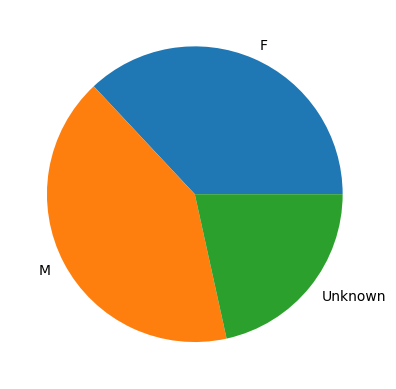

In [52]:
# create a pie chart using crime_victim_sex_df using plotly
import matplotlib.pyplot as plt
plt.pie(crime_victim_sex_df['dr_no'], labels=crime_victim_sex_df['vict_sex'])